### Test de modélisation avec un algo de classification "classique"

* Mise en oeuvre d'un réseau de neurones dense "simple"
* Application du tuto : https://www.tensorflow.org/tutorials/images/classification

### Import librairies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import time
import os
import pathlib
import shutil
import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
import pickle
from tensorflow.keras import datasets, layers, models, losses
import datetime

### Extraction d'un jeu de données réduit pour tester le premier modèle 

In [11]:
metadata = pd.read_csv("../../data/metadata_compil.csv")
metadata.head()
classes = metadata["CLASS"].unique()

In [30]:
def extract_subset(dossier_source, dossier_cible, nombre_par_classe):
    #Parcourir les dossiers du dataset préprocessé
    for c in os.listdir(dossier_source):
        sous_dossier = os.path.join(dossier_source, c)
        #boucle sur un array randomisé entre 1 et le nombre de fichiers du dossier, contenant le nombre_par_classe
        for file in np.random.choice(os.listdir(sous_dossier), nombre_par_classe, replace = False):
            #chemin d'accès au fichier soruce
            src = os.path.join(sous_dossier, file)
            #chemin d'accès du fichier copié
            dst = os.path.join(dossier_cible, c, file)
            #copie
            shutil.copyfile(src, dst)


In [158]:
dossier_source = "../../data/Preprocessing_1/" 
dossier_cible = "../../Data/Train_val_set_1/"
nb_par_classe = 500

start_time = time.time()
extract_subset(dossier_source, dossier_cible, nb_par_classe)
print("--- %s seconds ---" % (time.time() - start_time))


--- 23.876904487609863 seconds ---


### 1er réseau de neurones denses

In [2]:
#1 : Import du dataset et compte des images
dossier_train = "../../data/Train_set_2000"
data_dir = pathlib.Path(dossier_train).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print(f"{image_count} images dans le dataset")

2000 images dans le dataset


In [3]:
#2 : Chargement du dataset dans Keras
#define parameters for loader
batch_size = 32
img_height = 256
img_width = 256


#Create train set 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")

#Create validation set 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")


Found 2000 files belonging to 4 classes.
Using 1600 files for training.
Found 2000 files belonging to 4 classes.
Using 400 files for validation.


In [4]:
#You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['COVID', 'LUNG OPACITY', 'NORMAL', 'VIRAL PNEUMONIA']


In [5]:
#Configure dataset for performance with CACHE (not loading images at each epoch) and PREFETCH (overlapping data processing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [163]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 1)
(32,)


In [6]:
#Instanciation d'un premier modèle avec 2 couches 

num_classes = len(class_names)
#inputs = layers.Rescaling(1./255, input_shape=(img_height, img_width))
#first_layer = layers.Dense(16, activation = "tanh", kernel_initializer = "normal", name = "Dense1")
#second_layer = layers.Dense(4, activation = "softmax", kernel_initializer = "normal", name = "Dense2")
#x = first_layer(inputs)
#outputs = second_layer(x)
#model = Model(inputs = inputs, outputs = outputs)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
#  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6"),
], 
  name = "Modele_Dense_1")

#Compiler le modèle
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model summary
model.summary()



Model: "Modele_Dense_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 Dense2 (Dense)              (None, 128)               8388736   
                                                                 
 Dense5 (Dense)              (None, 32)                4128      
                                                                 
 Dense6 (Dense)              (None, 4)                 132       
                                                                 
Total params: 8392996 (32.02 MB)
Trainable params: 8392996 (32.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
#Définir les callbacks : Earlystopping, Tensorboard

#Early stopping
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience = 10,
    verbose = 1,
    restore_best_weights = True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
#Entraînement du modèle

#Train model
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [Early_Stopping, tensorboard_callback]
)

Epoch 1/30


50/50 [==============================] - 31s 549ms/step - loss: 1.7393 - accuracy: 0.4869 - val_loss: 1.0792 - val_accuracy: 0.5700
Epoch 2/30
50/50 [==============================] - 20s 353ms/step - loss: 0.9147 - accuracy: 0.6363 - val_loss: 1.0152 - val_accuracy: 0.5925
Epoch 3/30
50/50 [==============================] - 8s 158ms/step - loss: 0.7569 - accuracy: 0.6881 - val_loss: 1.0646 - val_accuracy: 0.5375
Epoch 4/30
50/50 [==============================] - 8s 156ms/step - loss: 0.6292 - accuracy: 0.7444 - val_loss: 1.0267 - val_accuracy: 0.6125
Epoch 5/30
50/50 [==============================] - 7s 145ms/step - loss: 0.5611 - accuracy: 0.7694 - val_loss: 1.0176 - val_accuracy: 0.5900
Epoch 6/30
50/50 [==============================] - 7s 146ms/step - loss: 0.4905 - accuracy: 0.8144 - val_loss: 1.0905 - val_accuracy: 0.5950
Epoch 7/30
50/50 [==============================] - 7s 146ms/step - loss: 0.5030 - accuracy: 0.8006 - val_loss: 1.3019 - val_accuracy: 0.5900
Ep

In [10]:
%load_ext tensorboard
#%reload_ext tensorboard

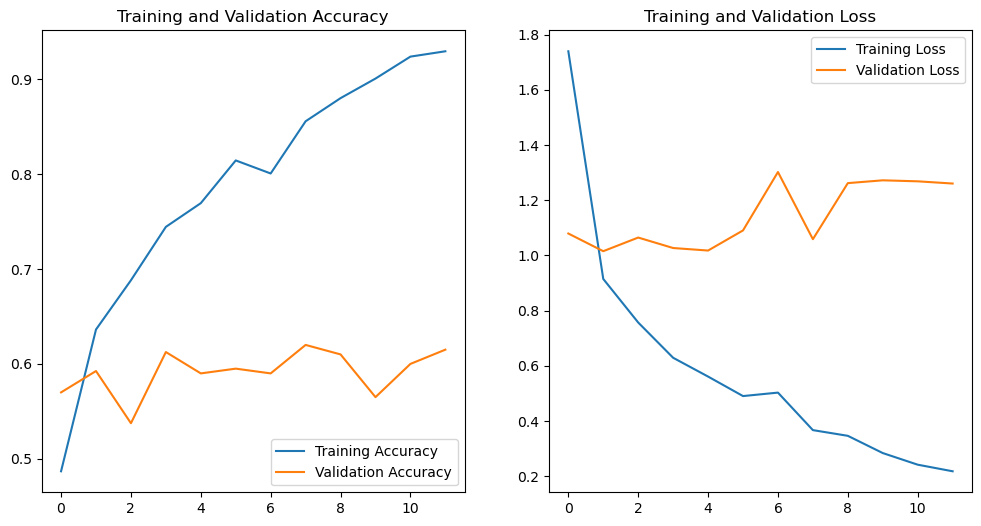

In [9]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





In [14]:
#Sauvegarde du modèle
dossier_sauv = "../../models/Thibaut/"
nom_modèle = f"{model._name}.-valacc{val_acc[-1]:.2f}.keras"
model.save(os.path.join(dossier_sauv, nom_modèle))  # The file needs to end with the .keras extension

12

In [15]:
#Export results to dict & csv
#Nom modèle : model._name, date: , dataset folder, dataset size, ephocs : len(val_acc), best_model : train_acc, val_acc, train_loss, val_loss
#datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Dump to a pickle file
# Pickle the history to file
filepath = f"{model._name}_history.pkl"
with open(filepath, 'wb') as f:
    pickle.dump(history, f)


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = f"{model._name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 2 Réseau de convolution

In [146]:
# Ajout de couches de convolution

num_classes = len(class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6")
])

#Compiler le modèle
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 131072)           

In [147]:
#Entraînement du modèle

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Train model
epochs=15
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/15
13/13 [==============================] - 161s 11s/step - loss: 1.5886 - accuracy: 0.3406 - val_loss: 1.3256 - val_accuracy: 0.3700
Epoch 2/15
13/13 [==============================] - 47s 4s/step - loss: 1.2278 - accuracy: 0.5069 - val_loss: 1.1794 - val_accuracy: 0.5025
Epoch 3/15
13/13 [==============================] - 42s 3s/step - loss: 1.0314 - accuracy: 0.5594 - val_loss: 1.0534 - val_accuracy: 0.5150
Epoch 4/15
13/13 [==============================] - 38s 3s/step - loss: 0.8520 - accuracy: 0.6319 - val_loss: 0.9817 - val_accuracy: 0.5525
Epoch 5/15
13/13 [==============================] - 45s 3s/step - loss: 0.6891 - accuracy: 0.7294 - val_loss: 0.9228 - val_accuracy: 0.5975
Epoch 6/15
13/13 [==============================] - 43s 3s/step - loss: 0.5632 - accuracy: 0.7850 - val_loss: 0.9525 - val_accuracy: 0.5675
Epoch 7/15
13/13 [==============================] - 45s 4s/step - loss: 0.4761 - accuracy: 0.8250 - val_loss: 1.0329 - val_accuracy: 0.5925
Epoch 8/15
13/13 [

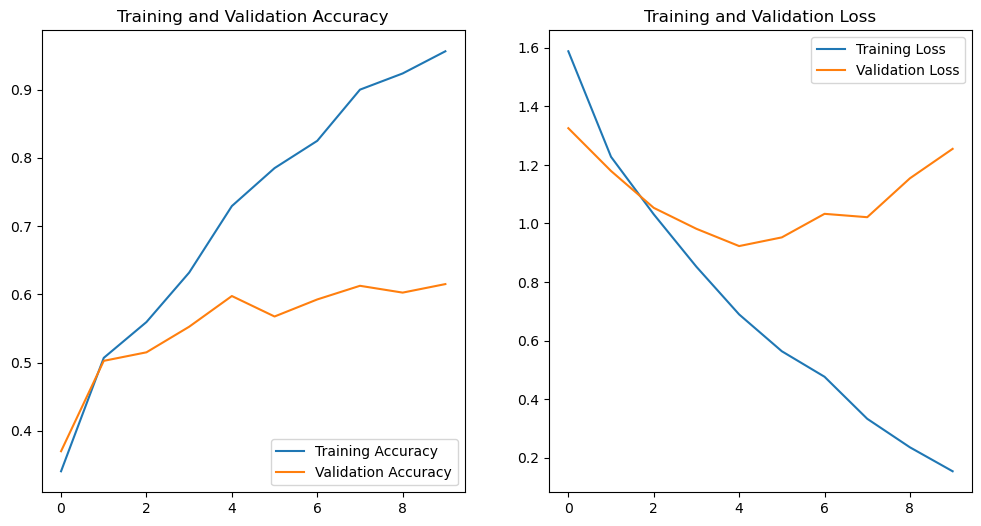

In [148]:
#Visualize training results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





In [149]:
#Sauvegarde du modèle
dossier_sauv = "../../models/Thibaut/"
nom_modèle = "Modèle2_CNN_1.keras"
model2.save(os.path.join(dossier_sauv, nom_modèle))  # The file needs to end with the .keras extension

# Prédiction pour 1 image


In [67]:
#Fonction qui load une image comme array en grayscale 256*256
def get_img_array_GS(img_path, size):
    # `img` is a PIL image of size 256*256
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256, 256) and convert to grayscale by reducing 4th dim
    array = np.expand_dims(array, axis=0)[:,:,:,1]
    return array

1/1 [==============================] - 0s 76ms/step


This image most likely belongs to NORMAL with a 35.99 percent confidence.
Logits par classe :  [('COVID', 0.07958507), ('LUNG OPACITY', 0.01973713), ('NORMAL', 0.6460484), ('VIRAL PNEUMONIA', 0.25462943)]
Probabilités par classe :  [('COVID', 0.20428044), ('LUNG OPACITY', 0.19241332), ('NORMAL', 0.35994712), ('VIRAL PNEUMONIA', 0.24335912)]


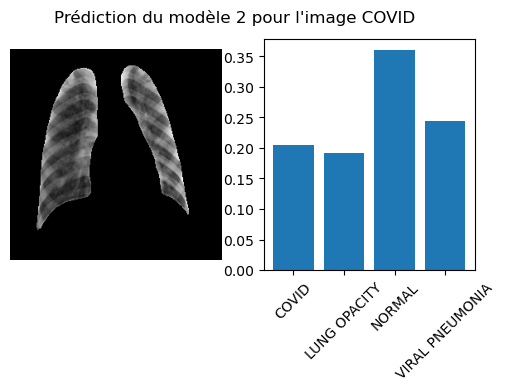

In [172]:
#Prédiction de la classe et du score sur 1 image
#KEras : Attach a softmax layer to convert the model's linear outputs—logits—to probabilities, which should be easier to interpret.
#Source : https://www.tensorflow.org/tutorials/keras/classification

img = get_img_array_GS("../../data/Train_val_set_1/VIRAL PNEUMONIA/Viral Pneumonia-472.png", size = (256,256))
true_class = "COVID" 
#Affichage de la prédiction
predict = model2.predict(img)
score = tf.nn.softmax(predict[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(
    "Logits par classe : ", list(zip(class_names, predict[0]))
)

print(
    "Probabilités par classe : ", list(zip(class_names, score.numpy()))
)

#Vérifier la prédiction de manière graphique 
i = 0
plt.figure(figsize=(6,3))
plt.suptitle(str("Prédiction du modèle 2 pour l'image " + true_class))
plt.subplot(1,2,1)
plt.imshow(img.reshape(256,256), cmap = "gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.bar(class_names, score.numpy())
plt.xticks(rotation=45)
plt.show()

# GRAD CAM pour visualiser la prédiction

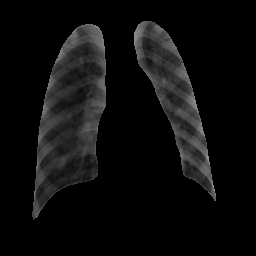

In [173]:
### GradCam pour visualiser l'activation
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#model_builder = keras.applications.xception.Xception
img_size = (256, 256)
#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_13"

# The local path to our target image
img_path = "../../data/Train_val_set_1/VIRAL PNEUMONIA/Viral Pneumonia-472.png"

display(Image(img_path))



In [152]:
#Fonction qui load une image comme array (pas utilisée ici)
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299*299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3) and convert to grayscale by reducing 4th dim
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
#    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #Réduit à 2 dims car image en GS
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #Réduit à 2 dims car image en GS

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 158ms/step
Probabilités par classe :  [('COVID', 0.20428044), ('LUNG OPACITY', 0.19241332), ('NORMAL', 0.35994712), ('VIRAL PNEUMONIA', 0.24335912)]


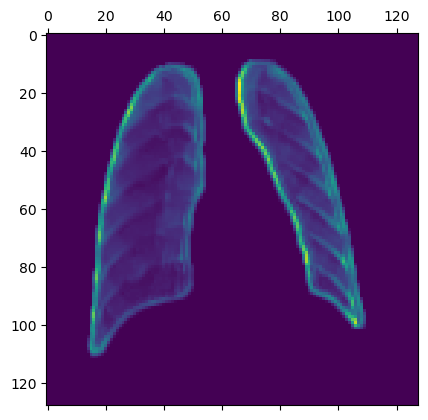

In [174]:
#img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array_GS(img_path, size=img_size)

# Make model
#model = model_builder(weights="imagenet")
model = model2

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])
score = tf.nn.softmax(preds[0])
print(
    "Probabilités par classe : ", list(zip(class_names, score.numpy()))
)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

C:\Users\thiba\AppData\Local\Temp\ipykernel_23176\665094926.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


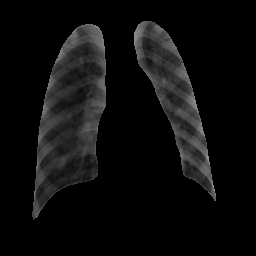

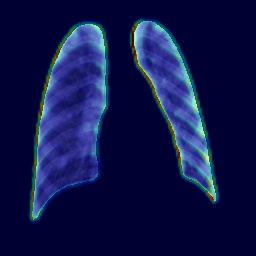

In [175]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(img_path))
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
